## 데이타 확인

훈련 샘플의 수: 8982
테스트 샘플의 수: 2246
클래스의 수 : 46
훈련용 뉴스의 최대 길이 :2376
훈련용 뉴스의 평균 길이 :145.5398574927633


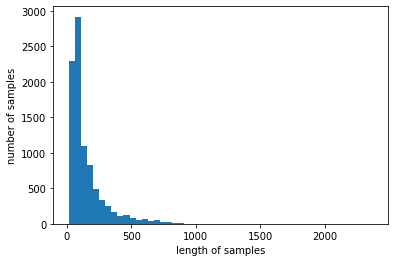

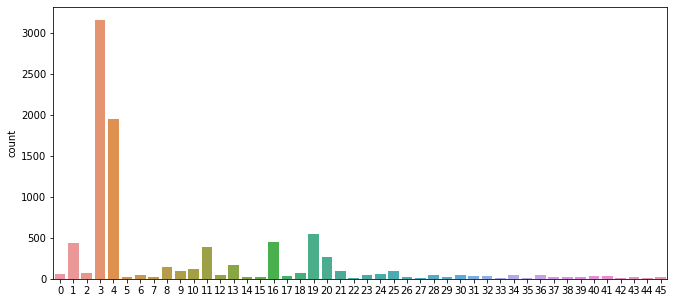

각 클래스 빈도수:
[[   0    1    2    3    4    5    6    7    8    9   10   11   12   13
    14   15   16   17   18   19   20   21   22   23   24   25   26   27
    28   29   30   31   32   33   34   35   36   37   38   39   40   41
    42   43   44   45]
 [  55  432   74 3159 1949   17   48   16  139  101  124  390   49  172
    26   20  444   39   66  549  269  100   15   41   62   92   24   15
    48   19   45   39   32   11   50   10   49   19   19   24   36   30
    13   21   12   18]]


In [1]:
from tensorflow.keras.datasets import reuters
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=10000, test_split=0.2)

print('훈련 샘플의 수: {}'.format(len(x_train)))
print('테스트 샘플의 수: {}'.format(len(x_test)))

num_classes = max(y_train) + 1
print('클래스의 수 : {}'.format(num_classes))

print('훈련용 뉴스의 최대 길이 :{}'.format(max(len(l) for l in x_train)))
print('훈련용 뉴스의 평균 길이 :{}'.format(sum(map(len, x_train))/len(x_train)))

plt.hist([len(s) for s in x_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(11,5)
sns.countplot(x=y_train)
plt.show()

unique_elements, counts_elements = np.unique(y_train, return_counts=True)
print("각 클래스 빈도수:")
print(np.asarray((unique_elements, counts_elements)))

## Vocab Size별 데이타 로딩 및 단어장 구성

In [2]:
# word index
word_index = reuters.get_word_index(path="reuters_word_index.json")

#<pad>, <sos>, <unk>
index_to_word = { index+3 : word for word, index in word_index.items() }
# index_to_word에 숫자 0은 <pad>, 숫자 1은 <sos>, 숫자 2는 <unk>를 넣어줍니다.
for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
    index_to_word[index]=token

In [3]:
## word_num별로 train, test를 가져오고, 단어장을 생성하는 함수

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer



def decode_to_text( text ) :
    decoded_text = []
    for i in range(len( text)):
        t = ' '.join([index_to_word[index] for index in text[i]])
        decoded_text.append(t)
    
    return decoded_text


def load_reuters_by_vocab_sizes():
    
    data_by_vocab = {}
    #DTM
    dtmvector = CountVectorizer()
    #TF-IDF
    tfidf_transformer = TfidfTransformer()

    for size in vocab_sizes:
        (x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=size, test_split=0.2)
         
        decoded_train = decode_to_text( x_train )
        decoded_test = decode_to_text( x_test )
        
        # DTM으로 변환
        dtm_train= dtmvector.fit_transform(decoded_train)
        dtm_test = dtmvector.transform(decoded_test) 
        
        #DTM을 TF-IDF 행렬로 변환
        tfidfv_train = tfidf_transformer.fit_transform(dtm_train)
        tfidfv_test = tfidf_transformer.transform(dtm_test) 
        
        data_by_vocab[size] = {
            'x_train': x_train,  #
            'y_train': y_train,
            'x_test': x_test, #
            'y_test': y_test,
            'decoded_train' : decoded_train, #
            'decoded_test' : decoded_test,  #
            'tfidfv_train' : tfidfv_train, 
            'tfidfv_test' : tfidfv_test
        }

    return data_by_vocab


**VOCAB_SIZE 분석**
전체 고유 토큰 수 (vocab size): 30980

전체 토큰 1638886, 상위 5000개 토큰 1530903
상위 5000개 토큰이 전체에서 차지하는 비중: 93.41%
Top 100 tokens coverage: 48.23%
Top 500 tokens coverage: 69.18%
Top 1000 tokens coverage: 78.31%
Top 2000 tokens coverage: 85.96%
Top 5000 tokens coverage: 93.41%
Top 10000 tokens coverage: 97.26%
Top 20000 tokens coverage: 99.29%
Top 30000 tokens coverage: 99.94%

In [ ]:
vocab_sizes = [None, 5000, 10000, 15000]
data_by_vocab = load_reuters_by_vocab_sizes()

In [4]:
print(data_by_vocab.keys())

def summarize_data_structure(data_by_vocab):
    """
    data_by_vocab의 구조를 요약해서 자동으로 출력하는 함수.
    각 vocab_size에 대해 훈련 데이터와 테스트 데이터의 크기 및 희소 행렬의 형태를 출력합니다.
    """
    for vocab_size, data in data_by_vocab.items():
        print(f"Vocab Size: {vocab_size}")
        
        # 훈련 데이터 크기
        train_data = data.get('tfidfv_train', None)
        if train_data is not None:
            print(f"  - 훈련 데이터 크기 (행, 열): {train_data.shape}")
            print(f"  - 훈련 데이터 문서 수: {train_data.shape[0]}")
        
        # 테스트 데이터 크기
        test_data = data.get('tfidfv_test', None)
        if test_data is not None:
            print(f"  - 테스트 데이터 크기 (행, 열): {test_data.shape}")
            print(f"  - 테스트 데이터 문서 수: {test_data.shape[0]}")
        
        print("-" * 40)

# 
summarize_data_structure(data_by_vocab)

dict_keys([None, 5000, 10000, 15000])
Vocab Size: None
  - 훈련 데이터 크기 (행, 열): (8982, 26506)
  - 훈련 데이터 문서 수: 8982
  - 테스트 데이터 크기 (행, 열): (2246, 26506)
  - 테스트 데이터 문서 수: 2246
----------------------------------------
Vocab Size: 5000
  - 훈련 데이터 크기 (행, 열): (8982, 4867)
  - 훈련 데이터 문서 수: 8982
  - 테스트 데이터 크기 (행, 열): (2246, 4867)
  - 테스트 데이터 문서 수: 2246
----------------------------------------
Vocab Size: 10000
  - 훈련 데이터 크기 (행, 열): (8982, 9670)
  - 훈련 데이터 문서 수: 8982
  - 테스트 데이터 크기 (행, 열): (2246, 9670)
  - 테스트 데이터 문서 수: 2246
----------------------------------------
Vocab Size: 15000
  - 훈련 데이터 크기 (행, 열): (8982, 14227)
  - 훈련 데이터 문서 수: 8982
  - 테스트 데이터 크기 (행, 열): (2246, 14227)
  - 테스트 데이터 문서 수: 2246
----------------------------------------


In [5]:
from sklearn.naive_bayes import MultinomialNB #다항분포 나이브 베이즈 모델
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score #정확도 계산

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# 1. 나이브 베이즈 분류기
mnb = MultinomialNB()

# 2. ComplementNB
cnb = ComplementNB()

# 3. 로지스틱 회귀(Logistic Regression)
lr = LogisticRegression(C=10000, penalty='l2', max_iter=3000)

# 4. 선형 서포트 벡터 머신(Linear Support Vector Machine)
lsvc = LinearSVC(C=1000, penalty='l1', max_iter=3000, dual=False)

# 5. 결정 트리(Decision Tree)
tree = DecisionTreeClassifier(max_depth=10, random_state=0)

# 6. 랜덤 포레스트(Random Forest)
forest = RandomForestClassifier(n_estimators=5, random_state=0)

# 7. 그래디언트 부스팅 트리(GradientBoostingClassifier)
grbt = GradientBoostingClassifier(random_state=0) # verbose=3

# 8. Voting
# 개별 모델 정의
log_clf = LogisticRegression(penalty='l2', solver='liblinear')  # L2 기본값이지만 명시함
nb_clf = ComplementNB()
gb_clf = GradientBoostingClassifier()

# VotingClassifier 정의 (soft voting)
voting_classifier = VotingClassifier(
    estimators=[('lr', log_clf), ('nb', nb_clf), ('gb', gb_clf)],
    voting='soft'
)


In [6]:
models_1 = [mnb, cnb, lr, lsvc, tree, forest]
models_2 = [grbt, voting_classifier]


In [7]:
test_results = []

def RunClassifier(models) :
   for model in models: 
        # 모델 이름 획득
        model_name = model.__class__.__name__
        
        for vocab_size, data in data_by_vocab.items():
            
            print(f"== ModelName: {model_name}, Vocab Size: {vocab_size}")
        
            tfidfv_train = data.get('tfidfv_train', None)
            tfidfv_test = data.get('tfidfv_test', None)
            y_train = data.get('y_train', None)
            y_test = data.get('y_test', None)
        
            if tfidfv_train is not None and tfidfv_test is not None:
                                    
                #훈련
                model.fit(tfidfv_train, y_train) 
                #테스트 데이터에 대한 예측
                predicted = model.predict(tfidfv_test) 
                #예측값과 실제값 비교
                accuracy =  accuracy_score(y_test, predicted)
                # 분류 성능 평가 (classification_report)
                cr = classification_report(y_test, predicted, zero_division=0, output_dict=True)
        
                print("   정확도:", round(accuracy, 5))
                print("   F1-Score:", round(cr['weighted avg']['f1-score'], 5))
        
        
                test_results.append({
                    'model': model_name, 
                    'vocab_size': vocab_size,
                    'val_accuracy': round(accuracy, 4),
                    'f1_score': round(cr['weighted avg']['f1-score'], 4)
                })
     

In [8]:

RunClassifier( models_1 )
            


== ModelName: MultinomialNB, Vocab Size: None
정확도: 0.5997328584149599
F1-Score: 0.5045670886188423
== ModelName: MultinomialNB, Vocab Size: 5000
정확도: 0.6731967943009796
F1-Score: 0.6012501291711391
== ModelName: MultinomialNB, Vocab Size: 10000
정확도: 0.6567230632235085
F1-Score: 0.5764467518778252
== ModelName: MultinomialNB, Vocab Size: 15000
정확도: 0.6331255565449688
F1-Score: 0.5498212868794679
== ModelName: ComplementNB, Vocab Size: None
정확도: 0.7649154051647373
F1-Score: 0.7346534179503126
== ModelName: ComplementNB, Vocab Size: 5000
정확도: 0.7707034728406055
F1-Score: 0.7458990404916549
== ModelName: ComplementNB, Vocab Size: 10000
정확도: 0.7707034728406055
F1-Score: 0.7456682614453047
== ModelName: ComplementNB, Vocab Size: 15000
정확도: 0.7720391807658059
F1-Score: 0.7448186439256785
== ModelName: LogisticRegression, Vocab Size: None
정확도: 0.8165627782724845
F1-Score: 0.8114428402876209
== ModelName: LogisticRegression, Vocab Size: 5000
정확도: 0.8036509349955476
F1-Score: 0.7985602317931111


/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


정확도: 0.7907390917186109
F1-Score: 0.7860690691781071
== ModelName: LinearSVC, Vocab Size: 5000


/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


정확도: 0.767586821015138
F1-Score: 0.7648247681558916
== ModelName: LinearSVC, Vocab Size: 10000


/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


정확도: 0.792520035618878
F1-Score: 0.7885655223331876
== ModelName: LinearSVC, Vocab Size: 15000


/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


정확도: 0.7876224398931434
F1-Score: 0.7825954146327979
== ModelName: DecisionTreeClassifier, Vocab Size: None
정확도: 0.6211041852181657
F1-Score: 0.5769283128518846
== ModelName: DecisionTreeClassifier, Vocab Size: 5000
정확도: 0.6179875333926982
F1-Score: 0.5729970881280324
== ModelName: DecisionTreeClassifier, Vocab Size: 10000
정확도: 0.6202137132680321
F1-Score: 0.5776398779280149
== ModelName: DecisionTreeClassifier, Vocab Size: 15000
정확도: 0.6193232413178985
F1-Score: 0.5755585664009136
== ModelName: RandomForestClassifier, Vocab Size: None
정확도: 0.6544968833481746
F1-Score: 0.6225909375608356
== ModelName: RandomForestClassifier, Vocab Size: 5000
정확도: 0.701246660730187
F1-Score: 0.6770217603524399
== ModelName: RandomForestClassifier, Vocab Size: 10000
정확도: 0.674087266251113
F1-Score: 0.6429484177284822
== ModelName: RandomForestClassifier, Vocab Size: 15000
정확도: 0.6714158504007124
F1-Score: 0.6406930098492383
{'model': 'MultinomialNB', 'vocab_size': None, 'val_accuracy': 0.5997, 'f1_score'

In [9]:
# 결과 출력
for result in test_results:
    print(result)

{'model': 'MultinomialNB', 'vocab_size': None, 'val_accuracy': 0.5997, 'f1_score': 0.5046}
{'model': 'MultinomialNB', 'vocab_size': 5000, 'val_accuracy': 0.6732, 'f1_score': 0.6013}
{'model': 'MultinomialNB', 'vocab_size': 10000, 'val_accuracy': 0.6567, 'f1_score': 0.5764}
{'model': 'MultinomialNB', 'vocab_size': 15000, 'val_accuracy': 0.6331, 'f1_score': 0.5498}
{'model': 'ComplementNB', 'vocab_size': None, 'val_accuracy': 0.7649, 'f1_score': 0.7347}
{'model': 'ComplementNB', 'vocab_size': 5000, 'val_accuracy': 0.7707, 'f1_score': 0.7459}
{'model': 'ComplementNB', 'vocab_size': 10000, 'val_accuracy': 0.7707, 'f1_score': 0.7457}
{'model': 'ComplementNB', 'vocab_size': 15000, 'val_accuracy': 0.772, 'f1_score': 0.7448}
{'model': 'LogisticRegression', 'vocab_size': None, 'val_accuracy': 0.8166, 'f1_score': 0.8114}
{'model': 'LogisticRegression', 'vocab_size': 5000, 'val_accuracy': 0.8037, 'f1_score': 0.7986}
{'model': 'LogisticRegression', 'vocab_size': 10000, 'val_accuracy': 0.8108, 'f1_

In [35]:
RunClassifier( models_2 )

== ModelName: GradientBoostingClassifier, Vocab Size: None
정확도: 0.7702582368655387
F1-Score: 0.7641672650539437
== ModelName: GradientBoostingClassifier, Vocab Size: 5000
정확도: 0.767586821015138
F1-Score: 0.7662475269931749
== ModelName: GradientBoostingClassifier, Vocab Size: 10000
정확도: 0.7662511130899377
F1-Score: 0.7622247724249729
== ModelName: GradientBoostingClassifier, Vocab Size: 15000
정확도: 0.7707034728406055
F1-Score: 0.7679654864390242
== ModelName: VotingClassifier, Vocab Size: None
정확도: 0.788512911843277
F1-Score: 0.7860193487661424
== ModelName: VotingClassifier, Vocab Size: 5000
정확도: 0.794746215494212
F1-Score: 0.7905654559375976
== ModelName: VotingClassifier, Vocab Size: 10000
정확도: 0.7889581478183437
F1-Score: 0.7860621349261226
== ModelName: VotingClassifier, Vocab Size: 15000
정확도: 0.7907390917186109
F1-Score: 0.7872400534732851


In [36]:
# 결과 출력
for result in test_results:
    print(result)

{'model': 'MultinomialNB', 'vocab_size': None, 'val_accuracy': 0.5997, 'f1_score': 0.5046}
{'model': 'MultinomialNB', 'vocab_size': 5000, 'val_accuracy': 0.6732, 'f1_score': 0.6013}
{'model': 'MultinomialNB', 'vocab_size': 10000, 'val_accuracy': 0.6567, 'f1_score': 0.5764}
{'model': 'MultinomialNB', 'vocab_size': 15000, 'val_accuracy': 0.6331, 'f1_score': 0.5498}
{'model': 'ComplementNB', 'vocab_size': None, 'val_accuracy': 0.7649, 'f1_score': 0.7347}
{'model': 'ComplementNB', 'vocab_size': 5000, 'val_accuracy': 0.7707, 'f1_score': 0.7459}
{'model': 'ComplementNB', 'vocab_size': 10000, 'val_accuracy': 0.7707, 'f1_score': 0.7457}
{'model': 'ComplementNB', 'vocab_size': 15000, 'val_accuracy': 0.772, 'f1_score': 0.7448}
{'model': 'LogisticRegression', 'vocab_size': None, 'val_accuracy': 0.8166, 'f1_score': 0.8114}
{'model': 'LogisticRegression', 'vocab_size': 5000, 'val_accuracy': 0.8037, 'f1_score': 0.7986}
{'model': 'LogisticRegression', 'vocab_size': 10000, 'val_accuracy': 0.8108, 'f1_

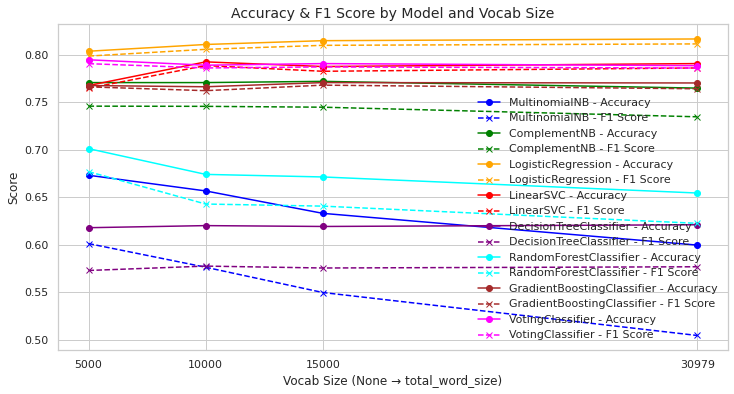

In [46]:
import pandas as pd
import matplotlib.pyplot as plt

# DataFrame 변환
df = pd.DataFrame(test_results)

total_word_size = len(word_index) 
# vocab_size가 None 또는 NaN인 경우 20000으로 치환
df['vocab_size_for_plot'] = df['vocab_size'].apply(
    lambda x: total_word_size if pd.isna(x) else int(x)
)

# 그래프 그리기
#plt.style.use('seaborn-darkgrid')
fig, ax = plt.subplots(figsize=(12, 6))

# 색상 지정 (모델 수만큼 색 준비)
colors = ['blue', 'green', 'orange', 'red', 'purple', 'cyan', 'brown', 'magenta']
model_names = df['model'].unique()
color_map = {model: colors[i % len(colors)] for i, model in enumerate(model_names)}

# 모델별 plot
for model_name in df['model'].unique():
    model_df = df[df['model'] == model_name].sort_values(by='vocab_size_for_plot')
    color = color_map[model_name]
    
    # Accuracy 선 + 점
    ax.plot(model_df['vocab_size_for_plot'], model_df['val_accuracy'], 
            marker='o', color=color, linestyle='-', label=f'{model_name} - Accuracy')
    
    # F1 Score 선 + 점
    ax.plot(model_df['vocab_size_for_plot'], model_df['f1_score'], 
            marker='x', color=color, linestyle='--', label=f'{model_name} - F1 Score')

# 레이블, 타이틀 등 설정
ax.set_title('Accuracy & F1 Score by Model and Vocab Size', fontsize=14)
ax.set_xlabel('Vocab Size (None → total_word_size)')
ax.set_ylabel('Score')
ax.legend()
# x축 눈금 강제 지정
xticks = sorted(df['vocab_size_for_plot'].unique())
ax.set_xticks(xticks)

#plt.grid(True)
plt.show()

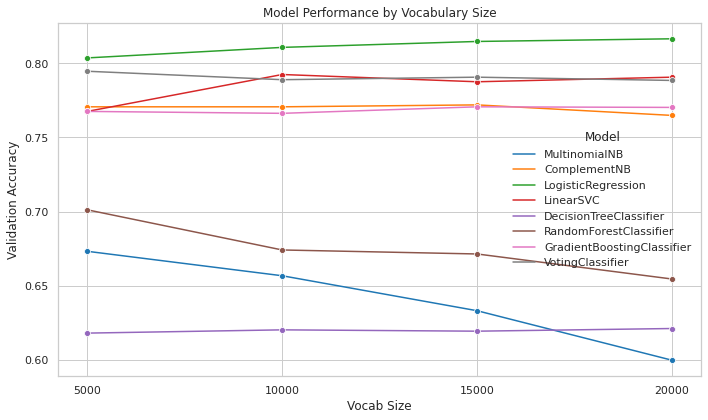

In [43]:
import seaborn as sns

# 스타일 설정
sns.set(style="whitegrid")

# 모델별 색상 다르게 선 그래프 그리기
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=df,
    x='vocab_size_for_plot',
    y='val_accuracy',
    hue='model',
    marker='o',
    palette='tab10'  # 최대 10가지 색상
)

plt.title('Model Performance by Vocabulary Size')
plt.xlabel('Vocab Size')
plt.ylabel('Validation Accuracy')
plt.legend(title='Model')
plt.xticks(df_clean['vocab_size_for_plot'].unique())
plt.grid(True)
plt.tight_layout()
plt.show()

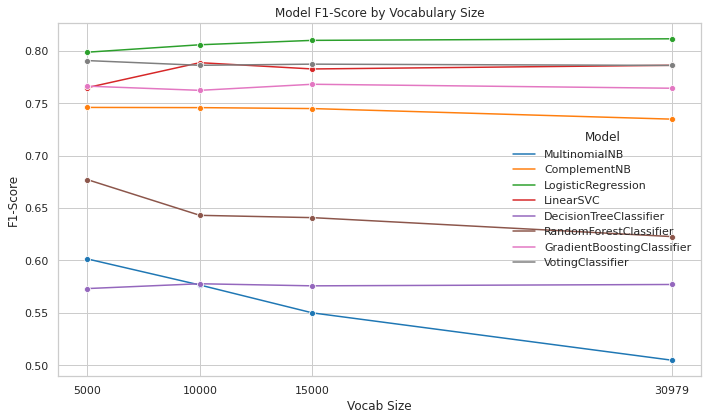

In [45]:
import seaborn as sns

# 스타일 설정
sns.set(style="whitegrid")

# 모델별 색상 다르게 선 그래프 그리기
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=df,
    x='vocab_size_for_plot',
    y='f1_score',
    hue='model',
    marker='o',
    palette='tab10'  # 최대 10가지 색상
)

plt.title('Model F1-Score by Vocabulary Size')
plt.xlabel('Vocab Size')
plt.ylabel('F1-Score')
plt.legend(title='Model')
plt.xticks(df['vocab_size_for_plot'].unique())
plt.grid(True)
plt.tight_layout()
plt.show()

## 딥러닝 FNN 모델 

In [47]:
import numpy as np

(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=None, test_split=0.2)


def decode_to_text( text ) :
    decoded_text = []
    for i in range(len( text)):
        t = ' '.join([index_to_word[index] for index in text[i]])
        decoded_text.append(t)
    
    return decoded_text
      
decoded_train = decode_to_text( x_train )
decoded_test = decode_to_text( x_test )


# 시퀀스를 이진 벡터로 변환 (Bag of Words 방식)
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        # ✅ dimension보다 작은 인덱스만 포함
        filtered_indices = [idx for idx in sequence if idx < dimension]
        results[i, filtered_indices] = 1.0
    return results

In [48]:
from tensorflow import keras
from tensorflow.keras import layers

def build_model(input_dim, num_classes=46):
    model = keras.Sequential([
        layers.Dense(64, activation="relu", input_shape=(input_dim,)),
        layers.Dense(64, activation="relu"),
        layers.Dense(num_classes, activation="softmax")
    ])

    model.compile(optimizer="rmsprop",
              loss="categorical_crossentropy",
              metrics=["accuracy"]
             )
    
    return model

In [49]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score #정확도 계산
from sklearn.metrics import classification_report



def DL_Classifier( vocab_sizes ) :
    
    dl_results = []
    
   #for model in models: 
        # 모델 이름 획득
        model_name = "DensLayer"
        
        for vocab_size in vocab_sizes:
            
            print(f"== ModelName: {model_name}, Vocab Size: {vocab_size}")
        
            
            # ✅ vocab_size가 None이면 디폴트 값으로 len(word_index) 사용
            vocab_dim = len(word_index) if vocab_size is None or pd.isna(vocab_size) else vocab_size
            
            # x_train 벡터화
            x_train_vec = vectorize_sequences(x_train, dimension=vocab_dim)
            x_test_vec = vectorize_sequences(x_test, dimension=vocab_dim)
            
            # y : one-hot encoding
            y_train_vec = to_categorical(y_train, num_classes)
            y_test_vec = to_categorical(y_test, num_classes)
            
        
            if x_train_vec is not None and x_test_vec is not None:
                 
                es = EarlyStopping(monitor='loss', patience=3, verbose=1)
                
                model = build_model(vocab_dim)
                #훈련
                history = model.fit(x_train_vec, y_train_vec, 
                                    epochs =20, 
                                    batch_size=512,
                                    callbacks = es
                                    )
                               
                #테스트 데이터에 대한 예측
                predicted = model.predict(x_test_vec) 
                
                # 예측값에서 가장 확률이 높은 클래스 인덱스 추출
                predicted_labels = np.argmax(predicted, axis=1)
                # 원-핫 인코딩된 정답을 정수 라벨로 변환
                true_labels = np.argmax(y_test_vec, axis=1)
                
                #예측값과 실제값 비교
                accuracy =  accuracy_score(true_labels, predicted_labels)
                
                # 분류 성능 평가 (classification_report)
                cr = classification_report(true_labels, predicted_labels, zero_division=0, output_dict=True)
        
                print("   정확도:", round(accuracy, 5))
                print("   F1-Score:", round(cr['weighted avg']['f1-score'], 5))
        
        
                dl_results.append({
                    'model': model_name, 
                    'vocab_size': vocab_size,
                    'val_accuracy': round(accuracy, 4),
                    'f1_score': round(cr['weighted avg']['f1-score'], 4)
                })

            


In [50]:
total_word_size = len(word_index) + 3
vocab_sizes = [total_word_size, 5000, 10000, 15000]

DL_Classifier( vocab_sizes )

== ModelName: DensLayer, Vocab Size: 30982
Epoch 1/20
18/18 [==============================] - 2s 36ms/step - loss: 2.5856 - accuracy: 0.5325
Epoch 2/20
18/18 [==============================] - 1s 36ms/step - loss: 1.3691 - accuracy: 0.7203
Epoch 3/20
18/18 [==============================] - 1s 36ms/step - loss: 0.9639 - accuracy: 0.7940
Epoch 4/20
18/18 [==============================] - 1s 38ms/step - loss: 0.7167 - accuracy: 0.8526
Epoch 5/20
18/18 [==============================] - 1s 39ms/step - loss: 0.5507 - accuracy: 0.8873
Epoch 6/20
18/18 [==============================] - 1s 36ms/step - loss: 0.4247 - accuracy: 0.9158
Epoch 7/20
18/18 [==============================] - 1s 36ms/step - loss: 0.3354 - accuracy: 0.9314
Epoch 8/20
18/18 [==============================] - 1s 37ms/step - loss: 0.2724 - accuracy: 0.9408
Epoch 9/20
18/18 [==============================] - 1s 36ms/step - loss: 0.2265 - accuracy: 0.9464
Epoch 10/20
18/18 [==============================] - 1s 36ms/step 

In [51]:
# 결과 출력
for result in dl_results:
    print(result)

{'model': 'DensLayer', 'vocab_size': 30982, 'val_accuracy': 0.7952, 'f1_score': 0.7859}
{'model': 'DensLayer', 'vocab_size': 5000, 'val_accuracy': 0.7841, 'f1_score': 0.7717}
{'model': 'DensLayer', 'vocab_size': 10000, 'val_accuracy': 0.7756, 'f1_score': 0.763}
{'model': 'DensLayer', 'vocab_size': 15000, 'val_accuracy': 0.7845, 'f1_score': 0.7728}


/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 49457 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 45733 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 49457 missing from current font.
  font.set_text(s, 0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 45733 missing from current font.
  font.set_text(s, 0, flags=flags)


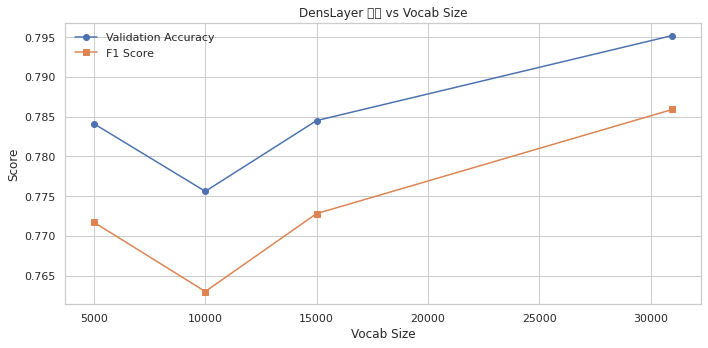

In [55]:
import pandas as pd
import matplotlib.pyplot as plt

# DataFrame으로 변환
df = pd.DataFrame(dl_results).sort_values(by="vocab_size")

# 그래프 그리기
plt.figure(figsize=(10, 5))
plt.plot(df["vocab_size"], df["val_accuracy"], marker="o", label="Validation Accuracy")
plt.plot(df["vocab_size"], df["f1_score"], marker="s", label="F1 Score")

plt.title("DensLayer 성능 vs Vocab Size")
plt.xlabel("Vocab Size")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 딥러닝 SimpleRNN 모델

In [63]:
from tensorflow import keras
from tensorflow.keras import layers

def build_rnn_model(input_dim, num_classes=46):
    model = keras.Sequential([
        layers.Embedding(input_dim=input_dim, output_dim=64),
        layers.SimpleRNN(64),
        layers.Dense(num_classes, activation="softmax")
    ])

    model.compile(optimizer="rmsprop",
              loss="categorical_crossentropy",
              metrics=["accuracy"]
             )
    
    return model

In [66]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score #정확도 계산
from sklearn.metrics import classification_report



def RNN_Classifier( vocab_sizes ) :
   #for model in models: 
        rnn_results = []
        # 모델 이름 획득
        model_name = "SimpleRNN"
        
        for vocab_size in vocab_sizes:
            
            print(f"== ModelName: {model_name}, Vocab Size: {vocab_size}")
        
            
            # ✅ vocab_size가 None이면 디폴트 값으로 len(word_index) 사용
            vocab_dim = len(word_index) if vocab_size is None or pd.isna(vocab_size) else vocab_size
            
            # x_train 벡터화
            x_train_vec = vectorize_sequences(x_train, dimension=vocab_dim)
            x_test_vec = vectorize_sequences(x_test, dimension=vocab_dim)
            
            # y : one-hot encoding
            y_train_vec = to_categorical(y_train, num_classes)
            y_test_vec = to_categorical(y_test, num_classes)
            
        
            if x_train_vec is not None and x_test_vec is not None:
                 
                es = EarlyStopping(monitor='loss', patience=3, verbose=1)
                
                model = build_rnn_model(vocab_dim)
                #훈련
                history = model.fit(x_train_vec, y_train_vec, 
                                    epochs =20, 
                                    batch_size=512,
                                    callbacks = es
                                    )
                               
                #테스트 데이터에 대한 예측
                predicted = model.predict(x_test_vec) 
                
                # 예측값에서 가장 확률이 높은 클래스 인덱스 추출
                predicted_labels = np.argmax(predicted, axis=1)
                # 원-핫 인코딩된 정답을 정수 라벨로 변환
                true_labels = np.argmax(y_test_vec, axis=1)
                
                #예측값과 실제값 비교
                accuracy =  accuracy_score(true_labels, predicted_labels)
                
                # 분류 성능 평가 (classification_report)
                cr = classification_report(true_labels, predicted_labels, zero_division=0, output_dict=True)
        
                print("   정확도:", round(accuracy, 5))
                print("   F1-Score:", round(cr['weighted avg']['f1-score'], 5))
        
        
                rnn_results.append({
                    'model': model_name, 
                    'vocab_size': vocab_size,
                    'val_accuracy': round(accuracy, 4),
                    'f1_score': round(cr['weighted avg']['f1-score'], 4)
                })


In [ ]:
RNN_Classifier( vocab_sizes )

In [ ]:
# 결과 출력
for result in rnn_results:
    print(result)

## 회고

### vocab_size 5000, 10000, 15000, None 4가지 시험 결과

- 8가지 머신러닝 모델에 대해서 vocab_size 5000, 10000, 15000, None 4가지로 시험하고, 
- 딥러닝 모델 중 FNN에 대해서 4가지 vocab_size에 대해서 시험한 결과를 아래 그래프로 정리하였다. 

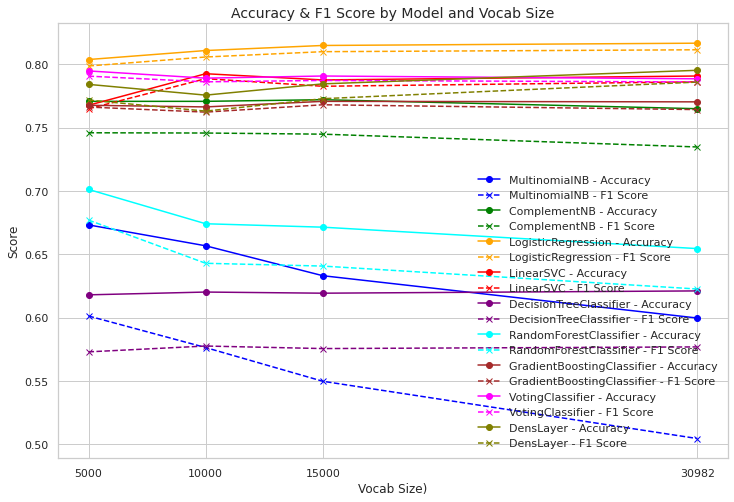

In [59]:
# 그래프 출력
df = pd.DataFrame(test_results)

total_word_size = len(word_index)+3 
df['vocab_size'] = df['vocab_size'].apply(
    lambda x: total_word_size if pd.isna(x) else int(x)
)

df2 = pd.DataFrame(dl_results)

df = pd.concat([df, df2], ignore_index=True)


# 그래프 그리기
#plt.style.use('seaborn-darkgrid')
fig, ax = plt.subplots(figsize=(12, 8))

# 색상 지정 (모델 수만큼 색 준비)
colors = ['blue', 'green', 'orange', 'red', 'purple', 'cyan', 'brown', 'magenta', 'olive']
model_names = df['model'].unique()
color_map = {model: colors[i % len(colors)] for i, model in enumerate(model_names)}

# 모델별 plot
for model_name in df['model'].unique():
    model_df = df[df['model'] == model_name].sort_values(by='vocab_size')
    color = color_map[model_name]
    
    # Accuracy 선 + 점
    ax.plot(model_df['vocab_size'], model_df['val_accuracy'], 
            marker='o', color=color, linestyle='-', label=f'{model_name} - Accuracy')
    
    # F1 Score 선 + 점
    ax.plot(model_df['vocab_size'], model_df['f1_score'], 
            marker='x', color=color, linestyle='--', label=f'{model_name} - F1 Score')

# 레이블, 타이틀 등 설정
ax.set_title('Accuracy & F1 Score by Model and Vocab Size', fontsize=14)
ax.set_xlabel('Vocab Size)')
ax.set_ylabel('Score')
ax.legend()
# x축 눈금 강제 지정
xticks = sorted(df['vocab_size'].unique())
ax.set_xticks(xticks)

#plt.grid(True)
plt.show()

In [62]:
# vocab_size 오름차순, val_accuracy 내림차순 정렬
df_sorted = df.sort_values(by=['vocab_size', 'val_accuracy'], ascending=[True, False])

# 결과 출력
print(df_sorted.to_string(index=False))

                     model  vocab_size  val_accuracy  f1_score
        LogisticRegression        5000        0.8037    0.7986
          VotingClassifier        5000        0.7947    0.7906
                 DensLayer        5000        0.7841    0.7717
              ComplementNB        5000        0.7707    0.7459
                 LinearSVC        5000        0.7676    0.7648
GradientBoostingClassifier        5000        0.7676    0.7662
    RandomForestClassifier        5000        0.7012    0.6770
             MultinomialNB        5000        0.6732    0.6013
    DecisionTreeClassifier        5000        0.6180    0.5730
        LogisticRegression       10000        0.8108    0.8057
                 LinearSVC       10000        0.7925    0.7886
          VotingClassifier       10000        0.7890    0.7861
                 DensLayer       10000        0.7756    0.7630
              ComplementNB       10000        0.7707    0.7457
GradientBoostingClassifier       10000        0.7663   

1. 가장 좋은 성능을 보인것은 accuracy 기준으로 ( LogisticRegression, None-vocab ) 이고, 
   LogisticRegression이 vocab_size별로도 가장 좋은 성능을 보였다. 
   
2. MultinominalNB 보다는 ComplementNB가 확실히 좋은 성능을 보였고, 
   DecisionTree가 라벨이 치우친 상황에서는 확실히 가장 낮은 성능을 보였다. 

3. Voting이 앙상블이라서 성능이 좋다고는 하였으나, LogisticRegression, ComplementNB,GradientBoostingClassifier가 섞여서, 
   LogisticRegression 단독보다는 낮은 성능을 보였다. 
   
4. vocab_size는 모델별로 성능이 다르게 나타나는데, 다수개의 모델에서는 5000개 vocab_size에서 좋은 성능을 보였다
   상위 5000개 토큰이 전체 text에서 차지하는 비중이 93.41%이므로 효율이 좋은 vocab_size로 보인다. 
   
5. 딥러닝 모델중 FNN 모델은 좋은 성능을 보이기는 하나, LogisticRegression보다는 낮은 성능을 보였다.
   FNN은 DenseLayer만 추가된 것이고, 단어 임베딩을 사용하지 않아서, 머신러닝보다 확연히 좋은 성능이 나오지는 않았다. 

6. 각각의 모델에 대해서는 grid search를 통해서 하이퍼파라미터 조정을 하면 더 좋은 성능이 보일것으로 예상된다. 

### 팀내 추가로 진행했던 100, 1000, 10000 vocab_size로 테스트한 결과에서, 
    - Top 100 tokens coverage: 48.23%
    - Top 1000 tokens coverage: 78.31%
    - Top 10000 tokens coverage: 97.26%
    테스트 결과를 보면, vocab_size rk 10000인 경우에 성능이 가장 좋았는데, (100 < 1000 < 10000 순)
    text를 포함하는 vocab_size가 90% 이상은 되어야 할 것으로 보인다. 

![accuracy_100_1000_10000](./image_accuracy.png)

![f1-score_100_1000_10000](./image_f1score.png)

### 기타 
- 딥러닝 모델들을 더 시험해보려고 했는데, GPU의 Memroy Resource 부족으로 더이상 진행하지 못해서 아쉽다. 